# Overview

Adaptive Waveform Inversion (AWI) is (in some ways) similar to the approach we worked out to the single trace transmission problem. It is based on an extension that's like one single trace transmission for every source-receiver pair: that is, every such pair gets its own wavelet, and the goal is to concentrate the wavelet near $t=0$ as much as possible. There are several notable differences. First, AWI presumes that a "true" wavelet, that generates the data, is known. So it's possible to focus on an "adaptive" kernel that produces the extended wavelet by convolution with the known "true" wavelet. This adaptive kernel really should be $\delta(t)$ at the correct model, so multiplication by $t$ is really an annihilator, without having to make a "small support" assumption. We could have done this as well, but of course we got an estimate of the wavelet for our trouble, without having to assume a known "true" wavelet. Second, AWI deals with multidimensional models, and many traces, not just one. 

There is some understanding to be gained by applying the methodology we developed to this larger scale problem. First, I'll review AWI as it is presented in the literature, along with a computational approach that makes it practical and an example. Next comes recasting AWI into the penalty form that we used in studying the single trace transmission problem, and a re-interpretation of a normalization as a preconditioner. Applied to transmission problems, I believe that AWI is not immune from stagnation at useless estimates - that was the motivation for Surface Source Extension inversion, which is a generalization. Finally, I do not believe that any of these techniques are any better than FWI when applied to reflection data. So there are two interesting negative results to be had. However we will also be able to explain exatly why AWI works, when it does work.

# Warner-Guasch formulation of AWI
 
The version of AWI introduced by Michael Warner and Lluis Guasch (SEG 2014 and *Geophysics* 2016) assumes that seismic waves are governed by linear acoustics, and that each shot is associated to an isotropic point source with known location and wavelet. That is, the pressure and velocity fields $p({\bf x},t;{\bf x}_s)$, ${\bf v}({\bf x},t;{\bf x}_s)$ for the shot location ${\bf x}_s$ depend on the bulk modulus $\kappa({\bf x})$, buoyancy $\beta({\bf x})$ (reciprocal of the density $\rho({\bf x})$), and wavelet $w(t;{\bf x}_s)$ through the acoustic system
 $$
 \frac{\partial p}{\partial t} = - \kappa \nabla \cdot {\bf v} +
w(t;{\bf x}_s) \delta({\bf x}-{\bf x}_s);
\frac{\partial {\bf v}}{\partial t} = - \beta \nabla p; 
p, {\bf v} = 0 \mbox{ for }  t \ll 0.
$$
For sake of brevity, define the model vector $m=(\kappa,\rho)$. The forward map or *modeling operator* is $F[m]w = \{p({\bf x}_r,t;{\bf x}_s)\}$, in which shot and receiver positions ${\bf x}_s, {\bf x}_r$ define the acquisition geometry.

For now, assume that the data $d({\bf x}_r,t;{\bf x}_s)$ is the output of the modeling operator for "true" model $m_*$, that is, the "true" bulk modulus, buoyancy, and wavelet $\kappa_*, \beta_*, w_*$: that is, $d = F[m_*]w_*$.

The extended modeling operator ${\bar F}$ maps extended sources $\bar{w}({\bf x}_r,t;{\bf x}_s)$ to the same sampling of the pressure field. That is, the extended source depends on the receiver location as well as the source location - so there is one acoustic system for each source *and* receiver position - a lot of wave equations! If all of the wavelets for each source are the same, that is, ${\bar w}({\bf x}_r,t;{\bf x}_s) = w(t;{\bf x}_s)$ is independent of receiver position, then ${\bar F}[m]\bar{w} = F[m]w$. That is, $F$ is a special case, or restriction, of ${\bar F}$, so ${\bar F}$ is an extension of $F$. This is the *source-recever* extension, in the terminology of Huang et al. 2015. 

AWI assumes that the extended sources are time convolutions of the (known) exact source with a kernel $\bar{u}({\bf x}_r,t;{\bf x}_s)$: $\bar{w} = \bar{u} * w_*$ - the asterisk denotes convolution in time. Since linear acoustics is time-translation invariant, its solution commutes with time convolution, that is,
$$
\bar{F}[m]\bar{w} = \bar{F}[m](\bar{u} * w_*).
$$
With this set-up, the object of inversion can be formulated as:

Given $d$, find $m=(\kappa, \beta)$ and $\bar{w}$ so that $u({\bf x}_r,t;{\bf x}_s) = \delta(t)$ (so $\bar{w}=w_*$) and $\bar{F}[m]\bar{w} = F[m]w_* \approx d$. 

Warner and Guasch assume (implicitly) that there is always a (near-)zero-residual solution of the extended inversion problem. That is, they assume that for any $m$, there is a $\bar{w}$ for which $\bar{F}[m]\bar{w} \approx d$. If $\kappa \approx \kappa_*, \beta \approx \beta_*$, then $\bar{w}$ should be $\approx w_*$, so the adaptive kernel $\bar{u}$ should be approximately $\delta(t)$ and independent of ${\bf x}_s,{\bf x}_r$. Such a $\bar{u}$ is (approximately) in the null space of multiplication by $t$. Thus a first version of the AWI algorithm:

1. Given $m$, solve the problem $\bar{F}[m]\bar{w} = d$ for $\bar{w}$. 
2. Deconvolve $w_*$ from $\bar{w}$ to obtain $\bar{u}$ for which $\bar{w}=u * w_*$. 
3. Compute the objective 
$$
J_0[m] = \int dx_s dx_r \left(\frac{\int dt |t\bar{u}|^2}{\int dt |\bar{u}|^2}\right)
$$
and its gradient, then update $\kappa,\beta$ by some gradient descent method. (The role of the normalization per source and receiver by the $L^2$ norm of $\bar{u}$ will be explained later.)

There are two things wrong with this algorithm. First, it involves way too many wave equation solves. Second, it depends on the assumption that you can fit the data exactly (which may or may not be the case, see examples to follow). Warner and Guasch fix the first problem. The second is fundamental, as will be shown below.

To solve the first problem, observe that the extended pressure field $\bar{p}$ is the convolution of the Green's function $G[m]$ (solution of the acoustic system above with $w(t,{\bf x}_s) = \delta(t)$) with the source function $w(t,{\bf x}_s)$. Since this source function is independent of the receiver position, only one wave equation needs to be solved for each source position, same as for non-extended modeling. Accordingly,
$$
\bar{F}[m]\bar{w} = G * \bar{w}
$$
Convolution is far cheaper than wave equation solve: thus the cost of computing the forward map is reduced to one wave equation solve per source, and one convolution per source and receiver.

On top of that, denote the convolution inverse of $G$ by $\check{G}$, and the convolution inverse of $w_*$ by $\check{w_*}$. Neither of these things may actually have a convolution inverse, strictly speaking. A solution of a regularized least-squares problem can play the same role. However these things are also cheaply approximated via discrete Fourier transform, which is what Warner and Guasch do. 

Then
$$
\bar{w} = \check{G} * d, \bar{u} =  \check{w_*}*\bar{w} = \check{w_*}*\check{G}*d
$$
and the first two steps in the above AWI algorithm can be replaced by inexpensive convolutions. This is the second version of the AWI algorithm. It is inexpensive enough to be employed on 3D data at field scale, as shown in various papers by Warner and collaborators.

# Example, part 1
I will build examples to illustrate various aspects of AWI using the Vector Calculus Library ("VCL"), described in the notebook *vcl.ipynb*. Use of the tools in this library reveals the parallels between the mathematical description of AWI (and similar algorithms) and implementations in code. The notebook *vcl.ipynb* describes the core ideas (implemented in the modules *vcl.py* and *vclalg.py*) and illustrates them using NumPy-based examples (module *npvc.py*).

To deal with seismic modeling and data, more complex data structures are required. These are developed in an informal way in the notebook *pyWAVE.ipynb*, which describes how two key types of data are stored in disk files and manipulated: trace data in the SEGY format, and regular grid data in the RSF format. This notebook employs vector calculus classes that wrap these disk formats and give them the attributes of vectors. 

The main observation underlying VCL is that vectors are data structures together with rules for manipulating them according to the axioms of linear algebra. Each of the two disk data strucures mentioned in the preceding paragraph gets a *vcl.Space* subclass, which defines the four attributes required of a vector space:
1. answer the question: does a data object belongs to a vector in the space?
2. produce a proper data object on request;
3. compute a linear combination of vectors; and
4. return the inner product of the vectors defined by two data objects.

The last item is included because the algorithms that interest us most rely on inner product structure. The implementing code resides in modules *segyvc.py* and *rsfvc.py*.

One of the initial puzzles one must solve to use tool sets like VCL is: how does one get started with an example? The answer: use software written at a lower level of abstraction to generate the core data on which all subsequent manipulations are based. Fortunately, such software already exists, in the modules *data.py* and *linalg.py*, described in *pyWAVE.ipynb*. These modules describe Python wrappers around commands from the Seismic Unix and Madagascar packages that directly manipulate the disk data structures of concern.

The examples to follow begin with the construction of several disk data sets of SEGY and RSF type, using tools from the *data.py* module:

In [1]:
import linalg
import data

######################## create data ###########################
# bulk modulus with lens
data.model(bulkfile='m.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20, lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)

# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='g.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)

0

You can check that the SEGY files *wstar.su* and *g.su*, and the RSF file *m.rsf*, are present in the working directory after the preceeding cell is run, and have the right attributes as revealed by *suedit*, *sfin*, and *sfattr*.

The disk data files are not in themselves usable as vectors; they must be combined with code that implements the four key attributes listed above. This necessary task is accomplished by creating specializations of *vcl.Space* based on the disk data:

In [2]:
import vcl
import segyvc
import rsfvc

###################### data spaces ##########################
bulksp = rsfvc.Space('m.rsf')
datasp = segyvc.Space('g.su')

To build a vector in one of these spaces, simply use the *vcl.Vector* constructor. To wrap the RSF data file *m.rsf* as a vector, use the name of the file as the optional second argument:

In [3]:
print('\nVector in bulksp = space based on m.rsf:\n')
x = vcl.Vector(bulksp)
x.myNameIs()

print('\nVector in bulksp that wraps m.rsf:\n')
m = vcl.Vector(bulksp,'m.rsf')
m.myNameIs()

print('\nnote: the vector data is a string (the filename): ' + m.data)


Vector in bulksp = space based on m.rsf:

Vector in space:
RSF Space based on file m.rsf
Data object:
RSF Header file = /var/tmp/tmp_rm20nfk.rsf

Vector in bulksp that wraps m.rsf:

Vector in space:
RSF Space based on file m.rsf
Data object:
RSF Header file = m.rsf

note: the vector data is a string (the filename): m.rsf


Every VCL type has a self-description attribute called *myNameIs*, that prints some (hopefully adequate) amount of information about the object on which it is called. Note the filename of the vector *x*: it is a "temporary" file, in the DATAPATH directory - by default, */var/tmp*, but controllable by the user. When the Python garbage collector is invoked, either at the end of the program or at the end of the block in which the variable *x* is assigned, this file will be deleted. The file *m.rsf*, on the other hand, is initialized externally to the vector *m* that wraps it, so it is flagged as "permanent', and will not be deleted unless the user explicitly inserts code to do so.

The main point of this structure, in either its informal or formal versions, is to set up seismic simulation and related operations. The informal version is the *fdop* function in *op.py*. It constructs a command-line string to call the RVL acoustic staggered grid simulator, *TRIP/iwave/asg/main/sim.x*. Most of the simulator arguments are built in to *fdop*. The formal VCL version is defined in the module *asg*. 

The arguments hidden in *fdop* are shown explicitly in the *vcl.Function* representation *asg.fsbop*, since this is supposed to more than just an illustration - these arguments may need to be changed, for example to introduce a pressure-release boundary condition. There are two arguments missing from the required list for *TRIP/iwave/asg/main/sim.x*, namely the bulk modulus (*bulkmod*, input) and the data traces (*data_p*, output). Those are actually the input and output arguments of the *vcl.Function* defined by *asg.fsbop*. The input bulk modulus is the function argument, as usual: if you call it *m*, then the output data traces are *F(m)*. 

There are two additional arguments, the first two, which are the domain and range spaces. All VCL functions know their domain and range, as all good functions should, and these are defined *externally to the function*, for reasons discussed in *vcl.ipynb*. The first two arguments to the the *asg.fsbop* constructor are (references to) the domain and range, represented as *vcl.Space* objects. When the function value *F(m)* is computed, the membership of *m* in the domain space is checked, then a vector in the range is generated and used to contain the output of the simulation, then passed back to the calling environment.

colmax=4.0 colmin=2.8009288


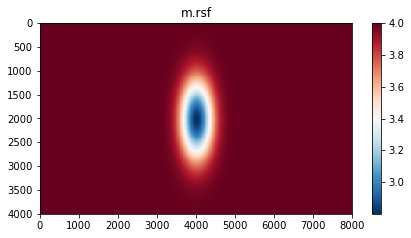

simplot: data min = 2.8009e+00, data max = 4.0000e+00
colmax=8.617457e-06 colmin=-8.617457e-06


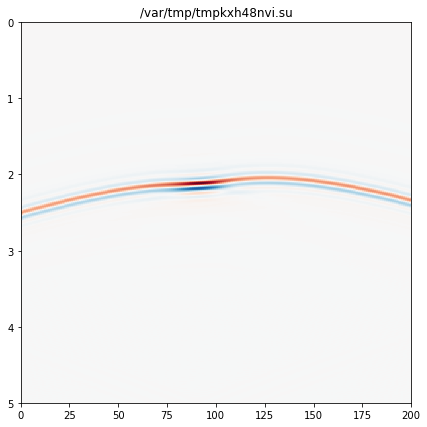

simplot: data min = -7.3256e-06, data max = 8.6175e-06


In [4]:
import asg

######################$ operator ############################
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bym.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)
########################## modeling ############################

# plot data stored in m
linalg.simplot(m.data, addcb=True)

# evaluate F[m]
Fm = F(m)

# plot data stored in Fm
linalg.simplot(Fm.data)

Note that *linalg.simplot* wants a filename argument. The filename of the output *Fm* is the data object of this vector, accessed as its *data* attribute. Since the vector *Fm* is allocated by the function evaluation *F(...)*, its data object is a temporary filename, as you see.

The name "fsbop" is an abbreviation for "fixed source and buoyancy operator". Note that the buoyancy *bym.rsf* (constructed by *data.model*) and the source wavelet *wstar.su* are passed to the constructor. They are passive parameters, not arguments of the function *F(...)* in this variant of the seismic simulator. Only the bulk modulus is regarded as variable.

To see that $F[m]$ is also the result of extended modeling, create a Green's function for the source and receiver positions - this requires a zero-phase delta function wavelet at the correct location, stored in discretized form in the file *delta.su*. Once again, this is best done with one of the *data.py* utilities, distinct from VCL. Since *delta.su* will be passed as the *source_p* argument, the function constructor generates a different function from *F*, as above; call it *Fdelta*. Note that *Fdelta* has the same domain and range spaces as *F*. Applying it generates the Green's function for the wave equation, within the finite difference approximation and with the constraints on time and space inherent in the domain and range spaces. 

To plot the Green's function, pass the data of the output *g* (a SEGY file name!) to *linalg.simplot*:

colmax=3.3351727e-05 colmin=-3.3351727e-05


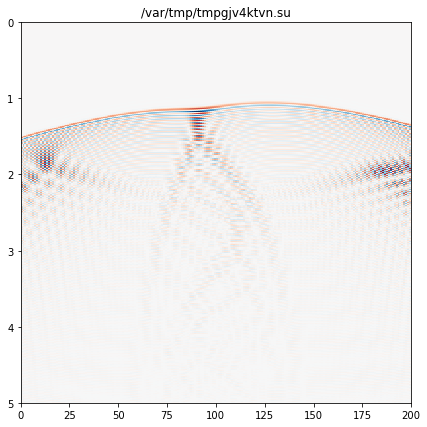

simplot: data min = -3.3352e-05, data max = 3.0076e-05


In [5]:
# create delta function at sx=4200, sz=3000 
data.delta(file='delta.su', nt=201, dt=8.0, sx=4200, sz=3000)

# apply fd op with delta wavelet to obtain green's fucntion
Fdelta = asg.fsbop(bulksp, datasp, buoyancy='bym.rsf',\
                source_p='delta.su', order=2, sampord=1, nsnaps=20,\
                cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
                nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)

g = Fdelta(m)

# take a look
linalg.simplot(g.data)

As shown in *pyWAVE.ipynb*, the convolutino of the Green's function with the soure wavelet yields the same result as the finite difference modeling operator with that wavelet. The VCL representation of convolution is the *vcl.LinearOperator* *segyvc.ConvolutionOperator*. As for other VCL operators, the domain and range spaces must be constructed externally. The range space is the same as that for the finite difference operators. The domain space is one that contains the wavelet (SEGY file) as vector data. The easiest way to cook that up is to use the wavelet SEGY file to initialize both the domain space of the *segyvc.ConvolutionOperator* and the vector in it:

colmax=8.617474e-06 colmin=-8.617474e-06


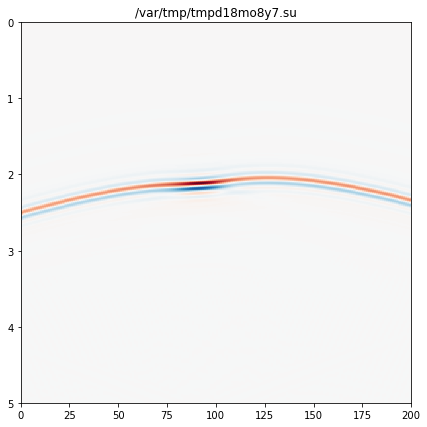

simplot: data min = -7.3256e-06, data max = 8.6175e-06


In [6]:
wsp = segyvc.Space('wstar.su')
Fconv = segyvc.ConvolutionOperator(wsp, datasp, g.data)

wstar = vcl.Vector(wsp,'wstar.su')

Fmconv = Fconv*wstar

linalg.simplot(Fmconv.data)

The resemblance with the finite difference output is obvious. In fact the two are within a reasonable multiple of macheps.

Next we establish that we can view the data as the output of an extended operator as well. Remember the AWI extension is provision of a separate source for every output data trace. So start by creating an extended source, replicating the bandpass filter for each trace (receiver position), with the same source/receiver locations as the data, replicating the single-trace bandpass filter in every trace. I have created a Python interface for the required SU commands to do this:

colmax=0.015873015 colmin=-0.015873015


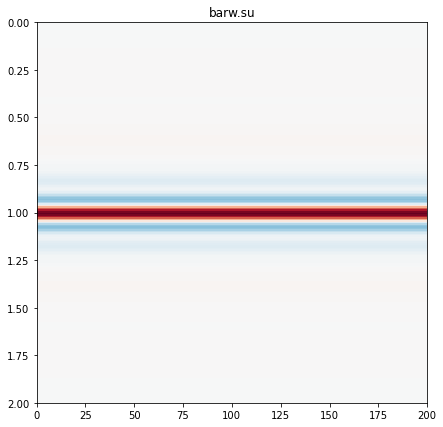

simplot: data min = -6.6359e-03, data max = 1.5873e-02


In [7]:
# extended source headers
data.bpfiltgather(file='barw.su',nt=251,dt=8.0,s=1.0,\
                  f1=1.0,f2=2.5,f3=7.5,f4=12,ntr=201,
                  sxstart=2000,szstart=6000,dsx=20,dsz=0)

# plot
linalg.simplot('barw.su')

Recall that the extended operators are denoted by an overbar. I will keep this convention by using "bar" as a prefix for the computational operator names. So the computational version of $\bar{F}[m]$ is *barF(m)*. To compute it, simply use *the same* Green's function as used in convolutional modeling, but with an extended source, that is, a gather of source traces, one per receiver position. *barw.su* is such a gather. 

The linear operator class *segyvc.ConvolutionOperator* calls *TRIP/iwave/trace/main/SEGYConv.x*, which is set up to recognize automatically that there is one input trace per receiver (that is, one input trace per trace in the Green's function) and perform the correct convolution, writing the result to the output trace. (It also works when there is only one input trace, as in the example above).

In this case, *barw.su* is the extended source that produces the same output as the single-trace source *wstar.su*, illustrating that $\bar{F}[m]$ is an extension of $F[m]$. Use *barw.su* to define a domain space (*segvc.Space*), and wrap it in a vector:

colmax=8.617474e-06 colmin=-8.617474e-06


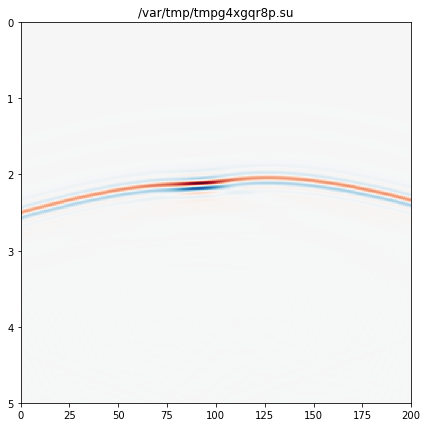

simplot: data min = -7.3256e-06, data max = 8.6175e-06
norm of barFm.su - Fm.su = 2.9694e-07
relative error = 5.8908e-04


In [8]:
# domain space
barwsp = segyvc.Space('barw.su')

# input vector
barw = vcl.Vector(barwsp,'barw.su')

# convolution operator, uses previously computed Green's function
barFmop = segyvc.ConvolutionOperator(barwsp,datasp,g.data)

# apply convolution operator
barFm = barFmop(barw)

# plot the result - same as plot of Fmwstar
linalg.simplot(barFm.data)

# compute the difference, norm, relative error
diffFm = vcl.Vector(Fm.space)
diffFm.copy(Fm)
diffFm.linComb(-1.0,barFm)
dnorm = Fm.norm()
diffnorm = diffFm.norm()

print('norm of barFm.su - Fm.su = %10.4e' % (diffnorm))
print('relative error = %10.4e' % (diffnorm/dnorm))


# Least squares formulation
Recall the convolutional representation of $\bar{F}$:
$$
\bar{F}[m]\bar{w} = G[m] * \bar{w}
$$
also the relation between the adaptive kernel $\bar{u}$, (known) source wavelet $w_*$, and extended source $\bar{w}$: 
$$
\bar{w} = \bar{u} * w_*
$$
Putting these together and using the commutativity of convolution,
$$
\bar{F}[m]\bar{w} = (G[m] * w_*) * \bar{u} = (F[m]w_*)*\bar{u} 
$$
In other words, the predicted *non-extended* data $F[m]w_*$ is the convolution kernel mapping the adaptive kernel $\bar{u}$ to predicted *extended* data $\bar{F}[m]\bar{w}$. 

This observation suggests reformulating the inverse problem directly in terms of the adaptive kernel $\bar{u}$: that is, find $\bar{u}$ so that
$$
\bar{S}[m,w_*]\bar{u} \equiv (F[m]w_*)*\bar{u} = \bar{F}[m](\bar{u}*w_*)
$$
approximates the data. Here $\bar{S}[m,w_*]$ is the operator of convolution with the *non-extended* predicted data $F[m]w_*$.

The straightforward least squares formulation would be: given $m, w_*, d$, find $\bar{u}$ to minimize (approximately)
$$
J_0[m,\bar{u};w_*,d] = \|\bar{S}[m,w_*]\bar{u}-d\|^2
$$

# Example, part 2

The domain space of $\bar{S}[m,w_*]$ consists of as many traces as the data or the Green's function, but presumably with a time range containing $t=0$. Since the ideal input is $\bar{u} = \delta(t)$, construct a gather consisting of 201 traces of length 2 s with the firast sample at $t=-1$ s to serve as the data of a *segyvc.SEGYSpace*

In [9]:
data.rechdr(file='baru.su',nt=251,dt=8.0,\
            ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20,delrt=-1000)

0

Then build an input *segyvc.Space* based on this file, and a *vcl.Vector* in it. For economy of storage, wrap 'baru.su' in this Vector:

In [10]:
usp=segyvc.Space('baru.su')
baru=vcl.Vector(usp,'baru.su')

The next step is to construct an Operator class (*segyvc.ConvolutionOperator*) wrapper around convolution, to simulate $\bar{S}[m,w_*]$. Note that a *vcl.Operator* "knows" its domain and range on construction, before its action on a vector is required. 

In [11]:
barSm = segyvc.ConvolutionOperator(dom=usp, rng=datasp, \
                                    green=Fm.data)

Note that the last argument is the file name of the non-extended predicted data *Fm.data*, which is the data object managed by *Fm*. This is typical of operator construction: some inputs are VCL class objects (like the domain and range spaces), while others will be other types of objects, whatever is necessary to carry out the internal processes of the operator.

The module *vcalg.py* defines a VCL version of CG for normal equations.

  k       |e|       |r|=
  0  5.0408e-04  1.8719e-07
  1  3.3561e-04  1.0975e-07
  2  2.0581e-04  7.2812e-08
  3  1.2930e-04  3.9290e-08
  4  9.5554e-05  2.3793e-08
  5  7.5952e-05  1.7822e-08
  6  6.1039e-05  1.3654e-08
  7  5.0831e-05  9.9050e-09
  8  4.4049e-05  7.9240e-09
  9  3.8560e-05  6.9622e-09
 10  3.3961e-05  5.9512e-09
 11  3.0333e-05  4.8226e-09
 12  2.7379e-05  4.2241e-09
 13  2.4957e-05  3.7756e-09
 14  2.2754e-05  3.2484e-09
 15  2.1045e-05  2.8519e-09
 16  1.9480e-05  2.6410e-09
 17  1.8041e-05  2.3875e-09
 18  1.6805e-05  2.1631e-09
 19  1.5697e-05  1.9614e-09
 20  1.4709e-05  1.8411e-09
 21  1.3845e-05  1.6301e-09
 22  1.3163e-05  1.4487e-09
 23  1.2564e-05  1.3330e-09
 24  1.2037e-05  1.2190e-09
 25  1.1524e-05  1.1711e-09
 26  1.1041e-05  1.1708e-09
 27  1.0516e-05  1.1659e-09
 28  9.9582e-06  1.1839e-09
 29  9.3933e-06  1.1257e-09
 30  8.8791e-06  1.0572e-09
 31  8.3847e-06  9.6522e-10
 32  7.9739e-06  8.5947e-10
 33  7.5982e-06  7.7233e-10
 34  7.2918e-06  7.1515

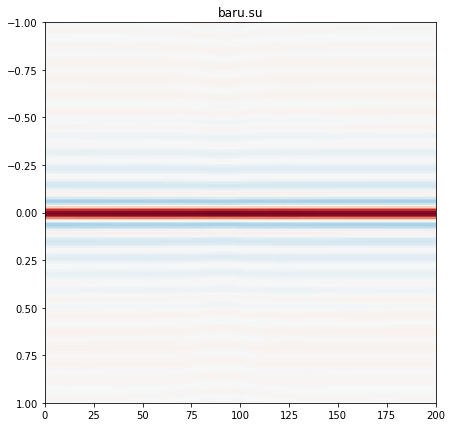

simplot: data min = -7.1111e-03, data max = 2.2034e-02


In [12]:
import segyvc
import vcalg
import linalg

# max allowed iterations
kmax = 50
# residual norm reduction for termination
eps  = 0.01
# normal residual norm reduction for termination
rho  = 0.001

try:
    vcalg.conjgrad(x=baru, b=Fm, A=barSm, \
                   kmax=kmax, eps=eps, rho=rho, verbose=2)
except Exception as ex:
    print(ex)
else:    
    linalg.simplot(baru.data)

The waveform is perfectly symmetric, independent of receiver location (trace index), and more focused at $t=0$ than the extended source 'barw.su', plotted above. Convolving 'baru.su' with 'wstar.su' would produce a close approximation of 'barw.su'.

By sheer luck, the relative error has just dropped below 1% at 50 iterations. If you plot the residual offline on the grey scale of the data (beyond the current capability of *linalg.simplot*), you can't really see it in most renderings. This is excellent data fit.

The next hypothesis to test is whether the extended model can fit the data well for any model $m$, correct or not. For example, we could use a constant bulk modulus $m0$ with $\kappa=4.0$, rather than the field with the lens that created the data 'Fmwstar.su'. A VCL implementation starts with FD computation of the non-extended simulation with inputs $m0$, represented by the RSF file 'm0.rsf', and the point source 'wstar.su'. Note that *m0.rsf* defines the same space as *m.rsf*, so there is no need to build a new domain space for the finite difference operator.

Note that since we have already defined the data space *dsp*, it's just as easy to create the non-extended predicted data *Fm0wstar* as a VCL Vector, accessing its data object (SEGY file name) as needed to pass to non-VCL functions. 

colmax=4.4665076e-06 colmin=-4.4665076e-06


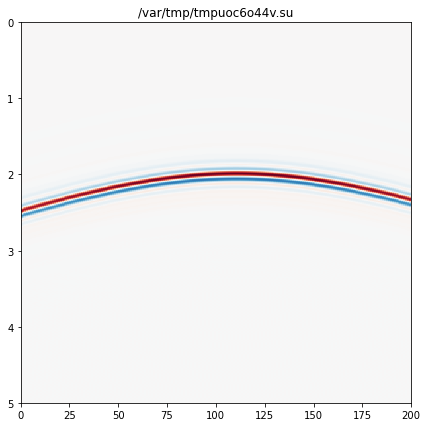

simplot: data min = -3.2286e-06, data max = 4.4665e-06


In [13]:
# homog bulk modulus = 4.0 GPa
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, \
           dx=20, dz=20, lensfac=1.0)

# define a vector in bulksp with this data
m0 = vcl.Vector(bulksp,'m0.rsf')

# compute non-extended predicted data from bulkmod m0
Fm0 = F(m0)

linalg.simplot(Fm0.data)

Note from the plot title that the file wrapped in the vector *Fm0wstar* is a temporary file, with a system-generated name. On exit from the Python process in which this notebook code is running, all such temporary files should be unlinked (deleted from the file system). I have not used the link method to replace this temporary file with a specified name, since there is no reason to make the data persistent beyond this process.

Now estimate an adaptive kernel *baru* that fits the data *Fmwstar* but with the *wrong* bulk modulus (hence wrong velocity or slowness). The modeling operator *Sm0* emulates $\bar{S}[m_0,w_*]$. All of the auxiliary parameters of the CG process are the same, and I have simply overwritten the adaptive kernel vector *baru* with the new data.

  k       |e|       |r|=
  0  5.0408e-04  1.3699e-07
  1  1.6184e-04  3.4390e-08
  2  8.4687e-05  1.3956e-08
  3  5.6591e-05  7.7766e-09
  4  4.1547e-05  5.1474e-09
  5  3.2391e-05  3.6067e-09
  6  2.6337e-05  2.7000e-09
  7  2.2025e-05  2.0837e-09
  8  1.8945e-05  1.6656e-09
  9  1.6564e-05  1.4070e-09
 10  1.4694e-05  1.1621e-09
 11  1.3203e-05  1.0130e-09
 12  1.1803e-05  9.3434e-10
 13  1.0648e-05  7.5653e-10
 14  9.7137e-06  6.8224e-10
 15  8.9392e-06  5.9918e-10
 16  8.2578e-06  5.2776e-10
 17  7.7215e-06  4.6694e-10
 18  7.2009e-06  4.6994e-10
 19  6.6328e-06  4.2703e-10
 20  6.2228e-06  3.3276e-10
 21  5.9353e-06  3.0919e-10
 22  5.6463e-06  2.9092e-10
 23  5.4011e-06  2.6165e-10
 24  5.1860e-06  2.3376e-10
 25  5.0110e-06  2.1586e-10
----------------------------------------------------
  k       |e|     |e|/|e0|      |r|        |r|/r0|
 25  5.0110e-06  9.9409e-03  2.1586e-10  1.5757e-03
colmax=0.042118285 colmin=-0.042118285


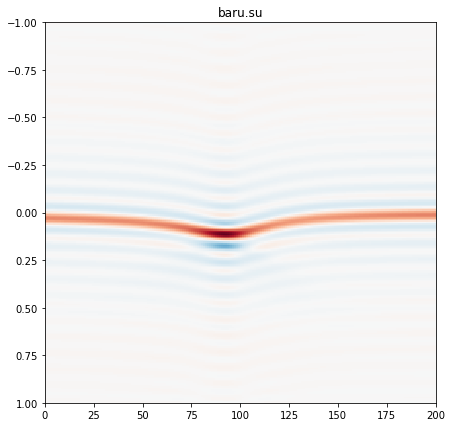

simplot: data min = -2.1222e-02, data max = 4.2118e-02


In [14]:
import segyvc
import vcalg
import linalg

Sm0 = segyvc.ConvolutionOperator(dom=usp, rng=datasp, \
                                green=Fm0.data)

vcalg.conjgrad(x=baru, b=Fm, A=Sm0, kmax=kmax, \
               eps=eps, rho=rho, verbose=2)

linalg.simplot(baru.data)

Two major things to notice: first, even though the bulk modulus (hence slowness, velocity) is incorrect, the data is fit. The relative error (enorm/enorm0 in the program output) is less than 0.01, at 25 iterations. This illustrates the assumption underlying AWI (and all other working extension methods: data can always be fit, even with the wrong model. The second thing to note is that the energy in the adaptive kernel baru.su computed with the homogeneous bulk modulus is delayed: it appears to arrive approximately 0.1 s late in the middle traces (80-120). This indicates that the model responsible for generating the data is slower in that region, which is correct (it has a slow lens in the middle). Measuring this delay by the norm-squared of the multiply-by-t operator applied to the adaptive kernel is the basic idea of AWI, and is very close in spirit to our treatment of the single-trace problem.

# Relation with penalty functions

Recall the AWI objective function: with the adaptive kernel $\bar{u}$ chosen so that $\bar{S}[m,w_*]\bar{u}=d$,
$$
J_0[m,w_*] = \sum_{x_s,x_r} \left(\frac{\int dt |t\bar{u}|^2}{\int dt |\bar{u}|^2}\right)
$$
This function is the $\alpha \rightarrow 0$ limit of a reduced penalty function:
$$J_0[m,w_*] = \lim_{\alpha \rightarrow 0} \frac{1}{\alpha^2}\tilde{J}_{\alpha}[m,w_*]
$$ 
where 
$$
\tilde{J}_{\alpha}[m,w_*] = \min_u J_{\alpha}[m,w_*,u]
$$
$$
= J_{\alpha}[m,w_*,\tilde{u}_{\alpha}[m,w_*]]
$$
with
$$
J_{\alpha}[m,w_*,u] = \frac{1}{2}(\|{\bar S}[m,w_*]u-d\|^2 + \alpha^2 \|Tu\|_m^2)
$$
Here $T$ is the multiply-by-$t$ operator, and $\|\cdot\|_m$ denotes a weighted norm:
$$
\|u\|_m^2 = \sum_{x_s,x_r} \left(\frac{\int dt |u|^2}{\int dt |\tilde{u}_0[m,w_*]|^2}\right)
$$
$$ 
= \|W[m,w_*]u\|^2
$$ 
The weight operator $W[m,w_*]$ multiplies the trace at $x_s,x_r$ by the reciprocal norm of the corresponding trace of $\tilde{u}_0[m,w_*]$, the solution of 
$$
\tilde{u}_0[m,w_*] = \mbox{argmin}_u \|\bar{S}[m,w_*]u-d\|^2
$$
Assuming that the minimum value on the RHS is actually zero, evidently the adaptive kernel $\bar{u}$ in the definition at the top of this paragraph is the same as $\tilde{u}_0[m,w_*]$. In general, some regularization is probably required for a proper definition of $\tilde{u}_0[m,w_*]$. It is the solution of a deconvolution problem. In the deconvolution context, (Tihonov) regularization is known as "pre-whitening". Warner and Guasch mention pre-whitening as part of their computations, though they do not give details.

# Why AWI works, and why the weighted norm is important

To see why AWI works, in at least some settings, assume that the spatial dimension is three. The 2D case has a similar conclusion but with somewhat more technical difficulty.

For spatial position ${\bf x}$ "not too far" from a source location ${\bf x}_s$, the Green's function has a useful decomposition:
$$
G[m]({\bf x},{\bf x}_s,t) = a[m]({\bf x},{\bf x}_s)\delta(t-\tau[m[({\bf x},{\bf x}_s)) + R[m]({\bf x},{\bf x}_s,t).
$$
This is the *geometric optics* (or *progressing wave*) decomposition. 
Assuming that the coefficients in the wave equation are smooth, the *amplitude* $a[m]$ and *travel time* $\tau[m]$are smooth, positive and well-defined in a punctured neighborhood $0<|{\bf x}- {\bf x}_s| < r$ of the source point ${\bf x}_s$. The *remainder* $R[m]$ is smooth except for a jump discontinuity at $t=\tau[m]({\bf x},{\bf x}_s)$, hence less singular than the leading $\delta$ term. It is "causal", that is, $=0$ for $t < \tau$. In this punctured ball of radius $r>0$, the decomposition of $G[m]$ stated above holds, but generally fails at distance $>r$ from the source. The radius $r$ depends on the slowness field: it is $=\infty$ for constant slowness, and is smaller for more oscillatory slowness. For a complete treatment of geometric optics as stated here, see Friedlander, *The wave equation on curved space-time*, Cambridge University Press, 1975. It is also described in Courant and Hilbert, *Methods of Mathematical Physics*, v. 2, Ch. VI, section 4, and in many other texts.

I will start by investigating the behaviour of the Warner-Guasch objective using the geometric optics tool, then turn to the penalty function. The analysis that follows is formal, in that I do not explicitly bound the error contributions from the remainder term $R[m]$ in any of the following expressions, acknowledging them by using the symbol $\approx$ rather than equality. Also, I tacitly assume that the geometric optics decomposition holds at all of the spatial locations of interest, that is,
$$
G[m]({\bf x},{\bf x}_s,t) \approx a[m]({\bf x},{\bf x}_s)\delta(t-\tau[m[({\bf x},{\bf x}_s)).
$$
I will eventually revisit this assumption, as one of the main points to be made is what happens to AWI when it fails.

Start by examining a particular source-receiver pair ${\bf x}_s,{\bf x}_r$, suppress from the notation. 
$$
F[m]w_*(t) \approx a[m]w_*(t-\tau[m])
$$
so 
$$
S[m,w_*]u(t) \approx a[m](w_**u)(t-\tau[m])
$$
Assume that the data is noise-free:
$$
d(t)=F[m_*]w_*(t) \approx a[m_*]w_*(t-\tau[m_*])
$$
The (approximate) solution of $S[m,w_*]u=d$ is obvious by inspection: $u(t) = a[m_*]/a[m]\delta(t-\tau[m_*]+\tau[m])$. There is immediately a big problem: this $u$ is not square-integrable, and the AWI objective defined above is undefined. To fix this, it's necessary to treat $u$ as the solution of a regularized least squares problem:
$$
u_{\epsilon} = \mbox{argmin}_u (\|S[m,w_*]u-d\|^2 + \epsilon^2\|u\|^2)
$$
$$
\approx \mbox{argmin}_u (\|a[m](w_**u)(\cdot-\tau[m])-a[m_*]w_*(\cdot-\tau[m_*])\|^2 + \epsilon^2\|u\|^2)
$$
Use the temporary abbreviations $a_*=a[m_*], a=a[m], \tau_*=\tau[m_*], \tau=\tau[m]$, and write in terms of the Fourier transforms $\hat{u}_{\epsilon},\hat{w_*}$ of $u_{\epsilon}$ and $w_*$:
$$
\hat{u}_{\epsilon} \approx \mbox{argmin}_{\hat{u}}\left(\int d\omega |a\hat{w_*}\hat{u}e^{i\omega \tau}-a_*\hat{w_*}e^{i\omega\tau_*}|^2 + \epsilon^2 |\hat{u}|^2\right)
$$
The normal equation is
$$
(a^2 |\hat{w}_*|^2 +\epsilon^2)\hat{u} = a a_*|\hat{w}_*|^2e^{i\omega(\tau_*-\tau)}
$$
the solution of which is
$$
\hat{u}_{\epsilon} \approx \frac{a^*}{a}\hat{g}_{\frac{a^*}{a}\epsilon} e^{i\omega(\tau_*-\tau)}
$$
where
$$ 
\hat{g}_{\epsilon} = \frac{a_*^2|\hat{w}_*|^2}{a_*^2|\hat{w}_*|^2 + \epsilon^2}.
$$
Since $w_* \in C_0^{\infty}$ (did I say that?), $\hat{w_*}(\omega) \rightarrow 0$ faster than any negative power of $\omega$ as $|\omega| \rightarrow \infty$ and is analytic, whence $\hat{g}_{\epsilon}: \epsilon > 0$ tends to $1$ almost everywhere as $\epsilon \rightarrow 0$. Hence the inverse Fourier transform $g_{\epsilon}$ tends to $\delta$ in the sense of distributions, and 
$$
u_{\epsilon}(t) \approx \frac{a^*}{a}g_{\frac{a^*}{a}\epsilon}(t-(\tau_*-\tau))
$$
to a multiple of a shifted $\delta$, in fact exactly the distribution solution of $\bar{S}[m,w_*]u=d$. However for $\epsilon>0$, $u_{\epsilon}$ is square integrable.

Analysis of the unweighted AWI objective (numerator of the formula above) with $u$ replaced by $u_{\epsilon}$ goes back to Huang and Symes SEG 2015:
$$
\int dt |tu_{\epsilon}|^2 \approx \frac{a_*^2}{a^2} \int dt\, t^2|g_{\frac{a^*}{a}\epsilon}(t-(\tau_*-\tau))|^2
$$
$$
=\frac{a_*^2}{a^2} \int dt\, (t+(\tau_*-\tau))^2|g_{\frac{a^*}{a}\epsilon}(t)|^2
$$
The linear (in t) term vanishes, since $g$ is necessarily even in time (since it Fourier transform is real). So this is
$$
=\frac{a_*^2}{a^2} \int dt\, t^2|g_{\frac{a^*}{a}\epsilon}(t)|^2
+(\tau_*-\tau)^2\frac{a_*^2}{a^2}\|g_{\frac{a^*}{a}\epsilon}\|^2
$$
The first term tends to zero as $\epsilon \rightarrow 0$, since $g_{\epsilon}$ is a delta-family, so you can make it negligible with proper choice of $\epsilon$. The second term suggests that this function is related to the travel-time error $\tau_*-\tau$. 

This is the key observation, since the travel-time error drives travel-time tomography and forcing it to zero forces $m$ to approximate $m_*$, at least for well-behaved smooth models. In other words, AWI may be travel-time tomography in disguise! This would explaing why AWI works, since travel-time tomography (fitting of travel times, rather than wave data) works.

However the amplitude terms - the presence of $a_*/a$ both as a multiplier and in the scaling of $\epsilon$ - may create stationary points for models differing in their travel time predictions. So stationary points of the unweighted AWI objective may not yield slowness models that match travel-times with the data, even in the noise-free case (even though the examples reported in Huang and Symes SEG 2015, and other works cited there, suggest that sometimes this is the case). 

The scaling by trace norms of $u_{\epsilon}$ (the weight operator, in other words) eliminates the possibility of non-travel-time stationary points. Since the objective function is built up trace-by-trace, use the same approximation for the norm of $u_{\epsilon}$: 
$$
\|u_{\epsilon}\| \approx \frac{a^*}{a}\|g_{\frac{a^*}{a}\epsilon}\|
$$
So
$$
J_0[m,w_*] \approx \sum_{{\bf x}_s,{\bf x}_r} (\tau[m_*]({\bf x}_s,{\bf x}_r)-\tau[m]({\bf x}_s,{\bf x}_r))^2
$$
ignoring the $\|tg_{...}\|^2$ term as being negligible for small enough $\epsilon$. 

In other words, the AWI objective is *exactly* an approximation to the travel-time tomography objective. And that's why it works - when geometric optics in the form given here is an accurate approximation to the Green's function.

It remains to see what geometric optics has to say about the penalty objective $\tilde{J}_{\alpha}[m,w_*]$, how geometric optics might fail, and what happens to AWI when it does.

# Example, part 3

Before exploring the VPM version of AWI, I will first sketch an implementation of FWI, since it is simpler but makes use of many of the same components.

The naive, unadorned FWI objective is
$$
J_{\rm FWI}[m; d] = 0.5 \|F[m]w_*-d\|^2
$$
Note that I haven't even included the wavelet $w_*$ in the objective notation. It is assumed known and fixed. In the language of our IP paper, this is the *restricted* FWI objective. The reduced objective, which also depends on the wavelet and is useful for estimating it, is more interesting, but it requires VPM, which is more complicated - I will discuss it later, as preparation for dealing with AWI.

As before, $m \mapsto F[m]w_*$ is represented by *asg.fsbop*. For a first example, let's suppose that the wavelet $w_*$ is *wstar.su*, as used in the previous examples, and the data are the noise-free traces $d=F[m]w_*$ with $m$ given by *m.rsf*, also as defined above. Then $d$ is the vector *Fm* used in the preceding examples - I rename it *d*. 

The VCL least squares class (*vcl.LeastSquares*) gives an easy construction of the FWI objective. I repeat some code from earlier, so that this cell and subsequent cells are independent of earlier cells.

In [15]:
import data
import vcl
import rsfvc
import segyvc
import asg

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
    
# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')
  
# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')
    
# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)
print('\nFD operator:')
F.myNameIs()
    
# evaluate F[mstar], create noise-free data
print('\nSimulated data (dstar)')
dstar = F(mstar)
dstar.myNameIs()

# least-squares function
JFWI = vcl.LeastSquares(F,dstar)


FD operator:
2D acoustic simulator: iwave/asg/main/sim.x
parameters:
 order=2 sampord=1 nsnaps=20 cfl=0.5 cmin=1.0 cmax=3.0 dmin=0.8 dmax=3.0 nl1=250 nr1=250 nl2=250 nr2=250 pmlampl=1.0
parameter bounds tested

Simulated data (dstar)
Vector in space:
SEGYSpace based on SEGY file data.su
Data object:
file with name = /var/tmp/tmpjytyiq26.su


The next step is to inspect some values of the FWI objective along a line segment in model space between the homogeneous model (which might be the starting model for the optimization) and the model *m* used to generate the data (the "target" model, as it is to be recovered by inversion). 

In [16]:
# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# value
print('value of JFWI at homog model = ' + str(JFWI(m0)))
# gradient
g0 = JFWI.gradient(m0)
print('norm of gradient at homog model = ' + str(g0.norm()))

vals=[]
m = vcl.Vector(bulksp)
#for i in range(0,10):
#    m.copy(m0)
#    t = float(i)/10.0
#    # m = t*mstar + (1-t)*m0
#    m.linComb(t,mstar,1.0-t)
#    vals.append(JFWI(m))
#    print('JFWI(' + str(t) + '*mstar+(1-' + str(t) + ')*m0) = ' + str(vals[i]))


value of JFWI at homog model = 2.10472e-07
norm of gradient at homog model = 2.5749796115697694e-09


Uh-oh!!! Starting at the homogeneous bulk modulus, the vector to the target model is not a descent direction! This is a common pattern in FWI. This observation does not necessarily show that another local minimum exists - it only shows that there are at least two local minima of the $J_{\rm FWI}$ *restricted to the line between $m_0$ and $m_*$*. To see that there might be another local min (not restricted to a line), you will have to go looking for it.

## Preliminary exercises

1. Compute and plot the gradient of $J_{\rm FWI}$ at each of the 10 points on the line segment from $m_0$ to $m_*$, for which the values are computed above. Does the gradient look like its negative is a good search direction for some of these points? Note: look at the code for *vcl.LeastSquares* - the gradient is already coded as the output of a method. You just need to use it.

2. Pick one of the models $(1-t)m_0 + t m_*$ for which the negative gradient looks like a constructive update direction, and do "manual steepest descent": guess a step in the negative gradient direction that should get the updated model close to the right one, add it, and do it again, a couple of times. How close can you get to the right model? To making $J_{\rm FWI} = 0$?

3. Change the "depth" of the lens in $m_*$: that is the parameter *lensfac* in *data.model*, which gives the ratio between the bulk modulus outside of the lens (which is constant in these models) and at the center of the lens. For *lensfac* = 0.4 or 0.3, the data traces are quite different from those produced by the homogeneous model $m_0$. You would expect the values of the objective to be larger, but is there more evidence of local minimizers? Does the gradient look much different?

# FWI, take 1

So let's apply the Steihaug Trust-Region Gauss-Newton algorithm to the FWI problem set up in the previous section. The bulk modulus 70\% along from $m_0$ to $m_*$ seems to be in the basin of convexity for this problem, or so one might infer from the values computed above. So let's try it. The various parameters to *vcalg.trgn* are documented in the source file.

In [17]:
    import vcalg
    
    m.copy(m0)
    t = 0.7
    # m = t*mstar + (1-t)*m0
    m.linComb(t,mstar,1.0-t)
    
    imax      =10
    eps       =0.01
    kmax      =20
    rho       =0.01
    Delta     =1000
    mured     =0.5
    muinc     =1.8
    gammared  =0.1
    gammainc  =0.9
    gnverbose =2
    cgverbose =2
    maxback   =10
    
    try:
        vcalg.trgn(m, dstar, F, imax, eps, kmax, rho, Delta, 
                   mured, muinc, gammared, gammainc, 
                   gnverbose, cgverbose, maxback=10)
    except Exception as ex:
        print(ex)
    


 GN Iteration 0
  i      J        |grad J|      Delta
  0  9.3455e-08  1.3598e-09  1.0000e+03
-------------------->>> CG >>>------------------------
  k       |r|        |r|/r0|
  0  1.3598e-09  1.0000e+00
  1  8.3006e-10  6.1044e-01
  2  2.0687e-10  1.5213e-01
  3  6.0721e-11  4.4656e-02
  4  5.1590e-11  3.7940e-02
  5  1.1509e-10  8.4637e-02
  6  2.6728e-11  1.9656e-02
  7  2.4378e-11  1.7928e-02
  8  1.7964e-11  1.3211e-02
  9  5.2573e-11  3.8663e-02
 10  1.2305e-11  9.0493e-03
--------------------<<< CG <<<------------------------
actred=5.07402e-08 predred=9.3119e-08
  1  4.2715e-08  5.3987e-10  1.0000e+03
-------------------->>> CG >>>------------------------
  k       |r|        |r|/r0|
  0  5.3987e-10  1.0000e+00
  1  3.6814e-10  6.8190e-01
  2  1.4114e-10  2.6144e-01
  3  1.0476e-10  1.9405e-01
  4  4.4011e-11  8.1521e-02
  5  2.5103e-11  4.6498e-02
  6  6.1097e-11  1.1317e-01
  7  1.7933e-11  3.3216e-02
  8  1.3738e-11  2.5446e-02
  9  7.4629e-12  1.3823e-02
 10  7.7580e-12 

Woops. In fact, the next bulk modulus had negative values - the step was too long, and violated the bound constraints on the velocity and density. These constraints are imposed so that the finite difference evolution of the acoustic field is well-defined. If the constraints are violated, the finite difference simulator won't work.



# FWI, take 2

Evidently it's necessary to use an algorithm that respects bounds. A simple one is described in *vcl.ipynb*. It works for simple bounds (not general constraints), by changing variables so that the entire real line (for each component) is mapped diffeomorphically onto the bound (open) interval. Then the mapping function can be composed with the simulator to produce a new simulator defined on $R^n$: in effect, the bounds have been built into the objective function. The present problem presents another obstacle, namely that the constraints are imposed on the velocity, whereas the optimization is to take place over bulk modulus. This is fixed by a further change of variable, so that in the end the domain of the modeling operator is a non-dimensional unbounded representation of velocity. Since the relation between this velocity representation and the bulk modulus (given the buoyancy or density) is $C^{\infty}$-invertible, stationary points of the original and modified objective functions are in 1-1 correspondence. 

In [18]:
# re-initialize everything, so you can start building the notebook here
import data
import vcl
import vcalg
import rsfvc
import segyvc
import asg
import os

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
    
# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')
  
# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')
    
# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)
    
# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
m = vcl.Vector(bulksp)
m.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
m.linComb(t,mstar,1.0-t)

# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp   = rsfvc.Space('cx.rsf')

# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf', 
                        cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# initial expanded velo model, corresponding to m
cx7 = inv(m)

# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf', 
                     cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# KGN in expanded velo space - same params as before
imax      =10
eps       =0.01
kmax      =20
rho       =0.01
Delta     =1000
mured     =0.5
muinc     =1.8
gammared  =0.1
gammainc  =0.9
gnverbose =2
cgverbose =2
maxback   =10
    
try:
    vcalg.trgn(cx7, dstar, Fmod, imax, eps, kmax, rho, Delta, 
               mured, muinc, gammared, gammainc, 
               gnverbose, cgverbose, maxback=10)
except Exception as ex:
    print(ex)



 GN Iteration 0
  i      J        |grad J|      Delta
  0  9.3455e-08  5.2724e-09  1.0000e+03
-------------------->>> CG >>>------------------------
  k       |r|        |r|/r0|
  0  5.2724e-09  1.0000e+00
  1  3.1567e-09  5.9871e-01
  2  7.8835e-10  1.4952e-01
  3  1.9359e-10  3.6718e-02
  4  2.4361e-10  4.6204e-02
  5  3.1363e-10  5.9486e-02
  6  1.0036e-10  1.9036e-02
  7  8.5481e-11  1.6213e-02
  8  6.2559e-11  1.1865e-02
  9  1.7682e-10  3.3538e-02
 10  4.6942e-11  8.9034e-03
--------------------<<< CG <<<------------------------
actred=5.85061e-08 predred=9.3005e-08
  1  3.4949e-08  1.7270e-09  1.0000e+03
-------------------->>> CG >>>------------------------
  k       |r|        |r|/r0|
  0  1.7270e-09  1.0000e+00
  1  9.9149e-10  5.7411e-01
  2  5.4045e-10  3.1294e-01
  3  2.1438e-10  1.2414e-01
  4  1.7042e-10  9.8682e-02
  5  1.3621e-10  7.8870e-02
  6  8.6045e-11  4.9823e-02
  7  4.5195e-11  2.6169e-02
  8  3.3008e-11  1.9113e-02
  9  3.9866e-11  2.3083e-02
 10  2.7782e-11 

Here is the result: the initial bulk modulus is plotted first, followed by the final bulk modulus output by *trgn*, followed by the "true" bulk modulus $m_*$. All plots on the same color scale. The *trgn* "solution" shows various "artifacts", such as oscillations around the source and receivers, some of which could be suppressed by regularizations of various types. However the main quality is the deeper lens, much closer in profile to the "true" lens.

colmax=4.5 colmin=2.5


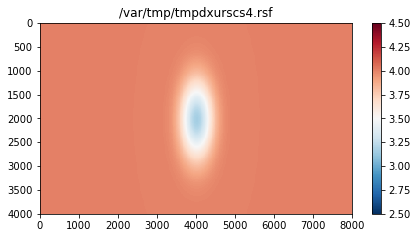

simplot: data min = 3.1607e+00, data max = 4.0000e+00
colmax=4.5 colmin=2.5


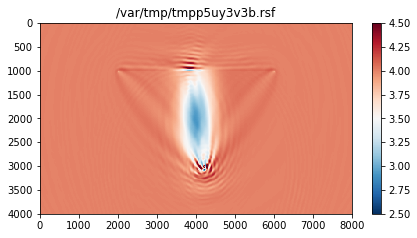

simplot: data min = 2.5855e+00, data max = 5.1895e+00
colmax=4.5 colmin=2.5


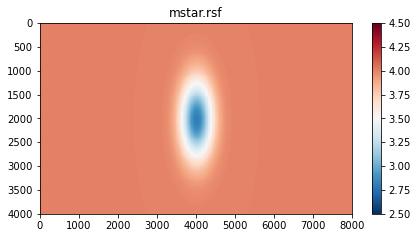

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [19]:
# plot data stored in m
import linalg
import vcl
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of KGN iteration, translated to bulkmod
mfin7 = fwd(cx7)
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

The important point is that the simulated data has become much closer, as indicated by the values of $J$ (from initial value of 9.3455e-08 to final value of 8.2390e-12). Here are plots (on the same scale/clip) of the initial and final seismograms and initial and final residuals (differences with $d_*=F(m_*)$):

colmax=4e-06 colmin=-4e-06


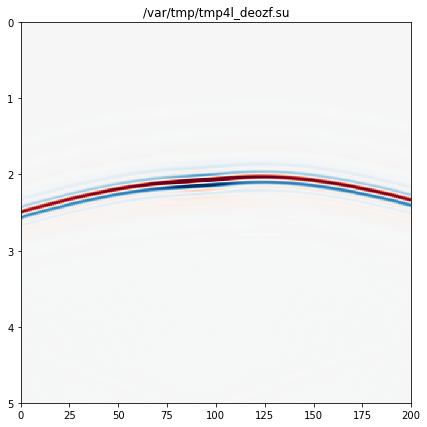

simplot: data min = -5.4178e-06, data max = 6.7892e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


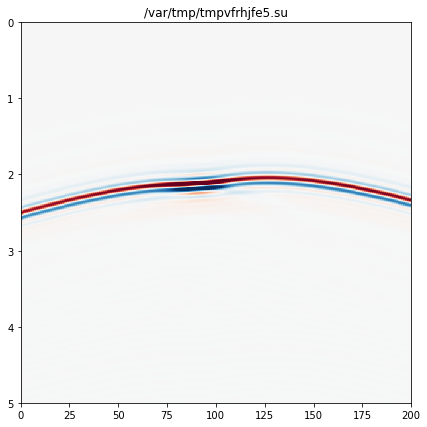

simplot: data min = -7.3469e-06, data max = 8.6081e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


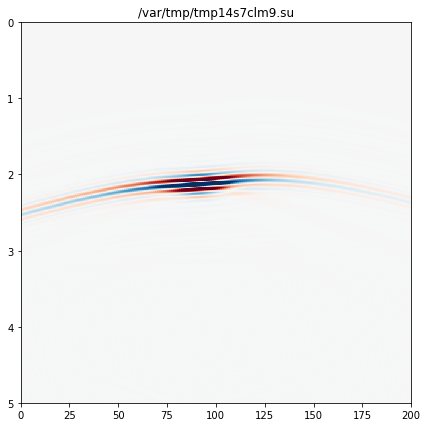

simplot: data min = -1.0579e-05, data max = 7.3968e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


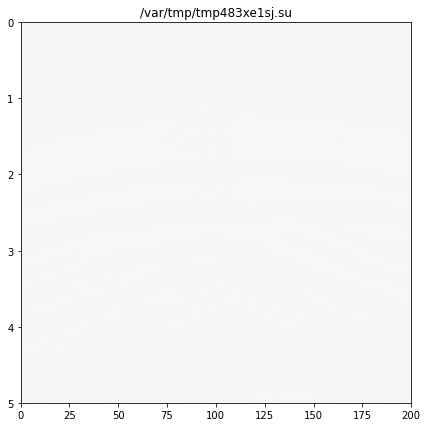

simplot: data min = -4.3694e-08, data max = 6.7741e-08
simplot: clip = 4.0000e-06
initial relative error = 1.9203e-08
final relative error   = 1.7636e-10


In [20]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7 = vcl.Vector(dbeg7.space)
rbeg7.copy(dbeg7)
rbeg7.linComb(-1.0,dstar)
rfin7 = vcl.Vector(dfin7.space)
rfin7.copy(dfin7)
rfin7.linComb(-1.0,dstar)

linalg.simplot(dbeg7.data,clip=4.0e-6)
linalg.simplot(dfin7.data,clip=4.0e-6)
linalg.simplot(rbeg7.data,clip=4.0e-6)
linalg.simplot(rfin7.data,clip=4.0e-6)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

The error in the final residual seismogram is less than 1\% of the data norm. For seismic data, that's an exact match.

Emboldened by our success, let's try again, but this time from the homogeneous model:

In [21]:
m.copy(m0)
t = 0.0
# m = t*mstar + (1-t)*m0
m.linComb(t,mstar,1.0-t)
# initial expanded velo model, corresponding to m
cx = inv(m)
    
imax      =10
eps       =0.01
kmax      =20
rho       =0.01
Delta     =1000
mured     =0.5
muinc     =1.8
gammared  =0.1
gammainc  =0.9
gnverbose =1
cgverbose =0
maxback   =10
gnorm0    =None
    
try:
    [Delta, gnorm0] = vcalg.trgn(cx, dstar, Fmod, imax, 
                     eps, kmax, rho, Delta, 
                     mured, muinc, gammared, gammainc, 
                     gnverbose, cgverbose, maxback)
except Exception as ex:
    print(ex)


 GN Iteration 0
  i      J        |grad J|      Delta
  0  2.1047e-07  1.0300e-08  1.0000e+03
  1  1.4529e-07  2.2829e-09  1.0000e+03
  2  8.8778e-08  1.0077e-09  5.0000e+02
  3  7.5241e-08  1.2320e-09  2.5000e+02
  4  4.2857e-08  1.0701e-09  2.2500e+02
  5  2.5435e-08  1.1262e-09  2.0250e+02
  6  1.5290e-08  8.1472e-10  2.0250e+02
  7  2.6260e-09  3.6260e-10  2.0250e+02
  8  1.0922e-09  1.4593e-10  2.0250e+02
  9  6.3126e-10  6.0051e-11  3.6450e+02
total function evals     = 14
total gradient evals     = 10
total CG steps           = 165


This is a much poorer result, however we are starting from further away, so perhaps that's to be expected - just further to go. Plotting the bulk modulus in the same way as before emphasizes just how unsatisfactory this inversion is:

colmax=4.5 colmin=2.5


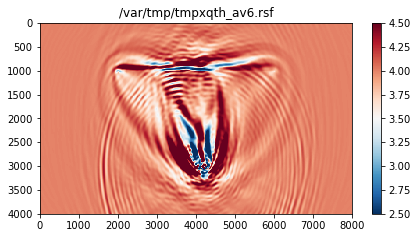

simplot: data min = 1.5843e+00, data max = 7.4188e+00
colmax=4.5 colmin=2.5


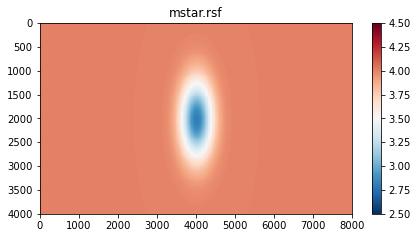

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [22]:
# plot result of KGN iteration, translated to bulkmod
mfin = fwd(cx)
linalg.simplot(mfin.data, addcb=True, minval=2.5, maxval=4.5)

# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

The recovered bulk modulus is of much poorer quality, with strong horizontal oscilation. Note that the final gradient norm, while not as small as was obtained in the previous example, is only an order of magnitude larger, and has decreased by two orders of magnitude from its intial value.

As always, the acid test is the degree to which the data is fit, or rather the extent to which the best possible data fit has been approximated. This data (*dstar*) is noise-free. Here is the comparison, with the simulated data at the beginning and final models, and the residuals, all plotted on the same scale (the same scale as was used to plot *dstar*, above).

colmax=4e-06 colmin=-4e-06


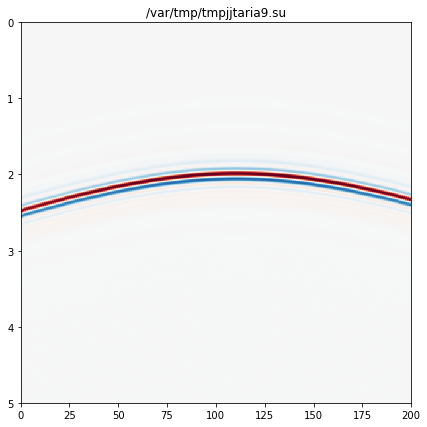

simplot: data min = -3.2286e-06, data max = 4.4665e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


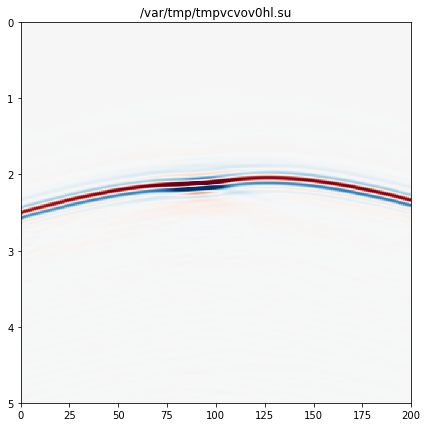

simplot: data min = -7.4955e-06, data max = 8.3467e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


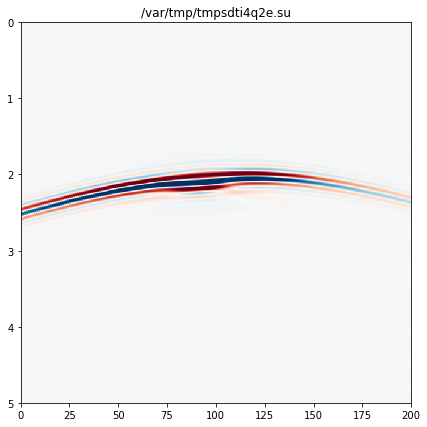

simplot: data min = -9.0827e-06, data max = 6.8966e-06
simplot: clip = 4.0000e-06
colmax=4e-06 colmin=-4e-06


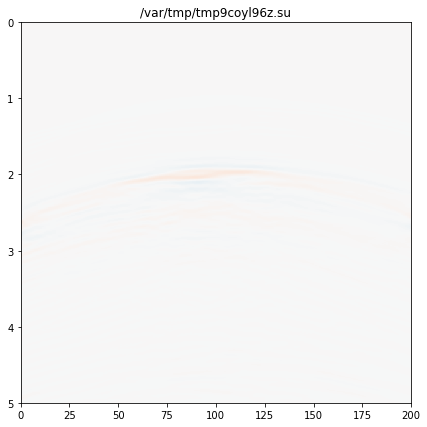

simplot: data min = -3.2820e-07, data max = 4.7507e-07
simplot: clip = 4.0000e-06
initial relative error = 2.8818e-08
final relative error   = 1.5782e-09


In [23]:
dbeg = F(m)
dfin = F(mfin)
rbeg=vcl.Vector(dbeg.space)
rbeg.copy(dbeg)
rbeg.linComb(-1.0,dstar)
rfin=vcl.Vector(dfin.space)
rfin.copy(dfin)
rfin.linComb(-1.0,dstar)

linalg.simplot(dbeg.data,clip=4.0e-6)
linalg.simplot(dfin.data,clip=4.0e-6)
linalg.simplot(rbeg.data,clip=4.0e-6)
linalg.simplot(rfin.data,clip=4.0e-6)

print('initial relative error = %10.4e' % (rbeg.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin.norm()/mstar.norm()))

To see more clearly how much more data residual there is, plot both the residual for $t=0.0$ (the last result) and $t=0.7$ (the previous one) with an order of magnitude smaller clip:  

colmax=4e-07 colmin=-4e-07


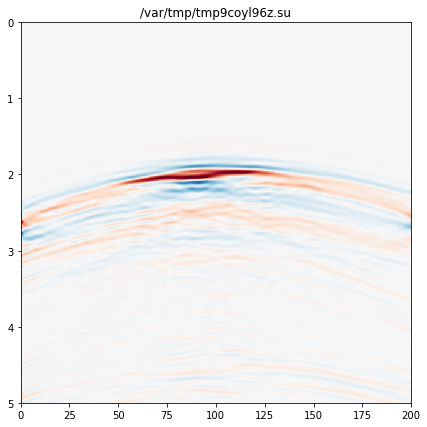

simplot: data min = -3.2820e-07, data max = 4.7507e-07
simplot: clip = 4.0000e-07
colmax=4e-07 colmin=-4e-07


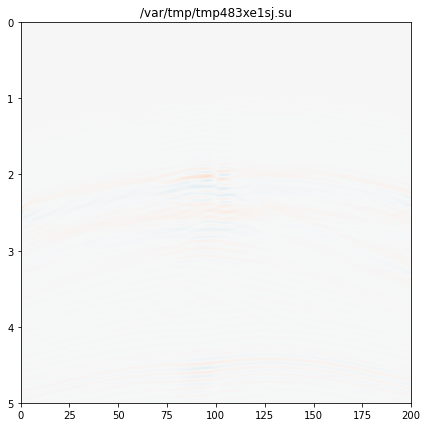

simplot: data min = -4.3694e-08, data max = 6.7741e-08
simplot: clip = 4.0000e-07
final relative error, t=0.0: 1.5782e-09
final relative error, t=0.7: 1.7636e-10


In [24]:
linalg.simplot(rfin.data,clip=4.0e-7)
linalg.simplot(rfin7.data,clip=4.0e-7)
print('final relative error, t=0.0: %10.4e' % (rfin.norm()/mstar.norm()))
print('final relative error, t=0.7: %10.4e' % (rfin7.norm()/mstar.norm()))

Since we know that the actual noise level in this data is 0.0, it's clear that the t=0.7 result is superior to the t=0.0 result, by an order of magnitude. But would we have known which to choose if we did not know the actual error level?

This situation is very common in practice, where the actual error level is never known with any precision. Practitioners distinguish between good inversion results and bad (cycle-skipped) ones by the model features. The "bad" result here might be rejected because the user does not expect to see very rapid horizontal changes in bulk modulus, and recognizes it as the signature of cycle-skipping. The better data fit produced by the other model might be taken as further evidence that it is closer to reality.

Of course, we got our "better" result by cheating, using an initial model that we happen to know is not too far off. Practitioners have a variety of tools (such as travel time tomography) to do a version of "cheating". AWI is an attempt to avoid the apparent trapping by cycle-skipped models shown in the last example, without resorting to data other than the seismic traces.

# AWI in penalty form

Recall that the AWI objective function is the $\alpha \rightarrow 0$ limit of a reduced penalty function:
$$J_0[m,w_*] = \lim_{\alpha \rightarrow 0} \frac{1}{\alpha^2}\tilde{J}_{\alpha}[m,w_*]
$$ 
where 
$$
\tilde{J}_{\alpha}[m,w_*] = \min_u J_{\alpha}[m,w_*,u]
$$
$$
= J_{\alpha}[m,w_*,\tilde{u}_{\alpha}[m,w_*]]
$$
with
$$
J_{\alpha}[m,w_*,u] = \frac{1}{2}(\|{\bar S}[m,w_*]u-d\|^2 + \alpha^2 \|T[m,w_*]u\|^2)
$$
Here $T$ is the multiply-by-$t$ operator, scaled by the reciprocal norm of the corresponding trace of $\tilde{u}_0[m,w_*]$, the solution of the $\alpha=0$ problem:
$$
\tilde{u}_0[m,w_*] = \mbox{argmin}_u \|\bar{S}[m,w_*]u-d\|^2
$$
$$
T[m,w_*]u(t,x_r, x_s) = tu(t,x_r,x_s)\left(\int dt'|\tilde{u}_0[m,w_*](t',x_r,x_s)|^2\right)^{-1/2} = \frac{tu(t,x_r,x_s)}{\|\tilde{u}_0[m,w_*](\cdot,x_r,x_s)\|}
$$
Note that the scaling by the reciprocal norm of $\tilde{u}_0$ is trace-by-trace - that is very important.

One of the goals of this project is documenting the importance of this scaling as a preconditioner. Therefore the implementation will offer it as an option.

The 

## NB: wavelet suppressed in notation
I have dragged the known source wavelet $w_*$ along throughout this whole discussion. Since it is unaltered by any of the proposed computations, I'm going to suppress it from the notation.

# Computation of the objective function
Like all penalty functions, this one is best viewed as a least-squares objective of a map with values in a product space: define
$$
A_{\alpha}[m] =  
\left[
\begin{array}{c}
S[m]\\
\alpha T[m]
\end{array}
\right]
, \, b = \left[
\begin{array}{c}
d\\
0
\end{array}
\right]
$$
Then
$$
J_{\alpha}[m,u] = 0.5\|A_{\alpha}[m]u-b\|^2
$$

Both Newton's method with the Kaufman Hessian approximation (described in the VCL notebook) and LBFGS or similar first-order methods apply to minimization of $\tilde{J}_{\alpha}[m]$. As shown in the VCL notebook, application of these algorithms to a VPM reduction like $\tilde{J}_{\alpha}$ requires access to two linear operator valued functions of $m$, namely $A_{\alpha}[m]$ and the derivative $D_m(A_{\alpha}[m]w)$. 

## Computing $A_{\alpha}[m]$
The two components are separate - in fact, the first component (map from wavelet to output trace) is convolutional, therefore diagonal in the frequency domain, whereas the second component is multiplication by a function of time, therefore diagonal in the time domain.

Step 1. Use the *asg.fsbop* finite difference operator as before to compute the predicted data *p* from the bulk modulus *m* and the wavelet *w* (assumed known!). The

Step 2. Define the domain of the AWI forward map, i.e. the space of adaptive kernels. Same number of traces as data, but time intervals symmetric about 0 and shorter, 2 - 3 times the length of the known wavelet trace. Define the convolutional operator $[m]$ from adaptive kernel to data, as the *segyvc.ConvolutionalOperator* with Green's functiopn = predicted data from step 1. $S[m]$ is the first component of the AWI operator.

Step 3. For the second component, use the *awi.awipen* class. The no-preconditioning case (precond=0) requires only the specification of the penalty weight *alpha*. The preconditioned case requires in addition the observed data, the predicted data, and CG parameters.

These steps are carried out in the next cell. Mostly focus on the penalty operator, since the AWI modeling operator has been discussed earlier. The penalty operator is applied to the AWI kernel solving the alpha=0 problem for two different choices of model, lens and homogeneous.


In [25]:
import linalg
import data
import vcl
import vcalg
import segyvc
import rsfvc
import asg
import os
import awi

    ################## domain, range spaces ###################

try:

    ### STEP 1. Define the forward modeling operator, compute the predicted
    ### data
    
    # bulk modulus with less focussing lens
    data.model(bulkfile='m.rsf', bulk=4.0, nx=401, nz=201,
                   dx=20, dz=20, lensfac=0.7)

    # homogeneous bulk modulus 
    data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201,
                   dx=20, dz=20, lensfac=1.0)

    # bandpass filter source at sx=4200, sz=3000 (single trace)
    data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,
                    f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
    linalg.scale('wstar.su',1.0e+3)
    
    # create zero data file with same source position, rz=500, rx=[2000,6000]
    data.rechdr(file='g.su',nt=626,dt=8.0,ntr=201,
                    rx=2000.0,rz=1000.0,sx=4200,sz=3000,drx=20.0)
    
    bulksp = rsfvc.Space('m.rsf')
    datasp = segyvc.Space('g.su')
    
    F = asg.fsbop(dom=bulksp, rng=datasp, \
                buoyancy='bym.rsf', source_p='wstar.su', \
                order=2, sampord=1, nsnaps=20,\
                cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
                nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)
    
    print('compute lens data')
    m = vcl.Vector(bulksp,'m.rsf')
    Fm = F(m)

    print('compute hom data')
    m0 = vcl.Vector(bulksp,'m0.rsf')
    Fm0 = F(m0)
    
    #### STEP 2: first component of AWI operator = convolution with predicted data
    #### two different models for this exercise: lens and homogeneous
    
    data.rechdr(file='baru.su',nt=251,dt=8.0,\
                ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20,delrt=-1000)
    usp=segyvc.Space('baru.su')
    barSm = segyvc.ConvolutionOperator(dom=usp, rng=datasp, 
                                        green=Fm.data)
    barSm0 = segyvc.ConvolutionOperator(dom=usp, rng=datasp, 
                                        green=Fm0.data)

    #### STEP 3: construct AWI penalty operator
    
    print('construct AWI penalty operator, precond=0')
    op0 = awi.awipen(dom=usp, alpha=1.e-4)

    barull = vcl.Vector(usp)
    baruhl = vcl.Vector(usp)
    pent0ll = vcl.Vector(usp)
    pent1ll = vcl.Vector(usp)
    pent0hl = vcl.Vector(usp)
    pent1hl = vcl.Vector(usp)

    print('construct AWI penalty operator, precond=1, case lens-lens')
    opll1 = awi.awipen(dom=usp, alpha=1.0e-4, precond=1,
                         d=Fm, p=Fm,
                         kmax=20, eps=0.01, rho=0.01, verbose=0)

    print('construct AWI penalty operator, precond=1, case hom-lens')
    ophl1 = awi.awipen(dom=usp, alpha=1.0e-4, precond=1,
                         d=Fm, p=Fm0,
                         kmax=20, eps=0.01, rho=0.01, verbose=0)    
    
    print('compute awi kernel in case lens-lens')
    vcalg.conjgrad(x=barull, b=Fm, A=barSm, kmax=20, eps=0.01, rho=0.01, verbose=0)

    print('apply AWI penalty operator, precond=1, case lens-lens')
    pent1ll = opll1*barull

    print('apply AWI penalty operator, precond=0, case lens-lens')
    pent0ll = op0*barull

    print('compute awi kernel in case hom-lens')
    vcalg.conjgrad(x=baruhl, b=Fm, A=barSm0, kmax=20, eps=0.01, rho=0.01, verbose=0)

    print('apply AWI penalty operator, precond=1, case hom-lens')
    pent1hl = ophl1*baruhl

    print('apply AWI penalty operator, precond=0, case hom-lens')
    pent0hl = op0*baruhl
    
except Exception as ex:
    print(ex)


compute lens data
compute hom data
construct AWI penalty operator, precond=0
construct AWI penalty operator, precond=1, case lens-lens
construct AWI penalty operator, precond=1, case hom-lens
compute awi kernel in case lens-lens
apply AWI penalty operator, precond=1, case lens-lens
apply AWI penalty operator, precond=0, case lens-lens
compute awi kernel in case hom-lens
apply AWI penalty operator, precond=1, case hom-lens
apply AWI penalty operator, precond=0, case hom-lens


AWI kernel, case lens-lens

colmax=0.02116563 colmin=-0.02116563


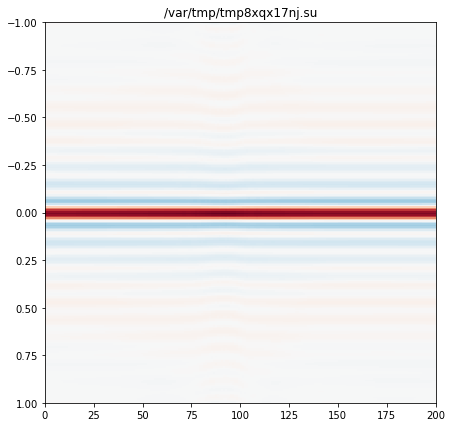

simplot: data min = -7.5694e-03, data max = 2.1166e-02


In [26]:
linalg.simplot(barull.data)

Output of AWI penalty op, precond=0, lens-lens

colmax=9.1570466e-05 colmin=-9.1570466e-05


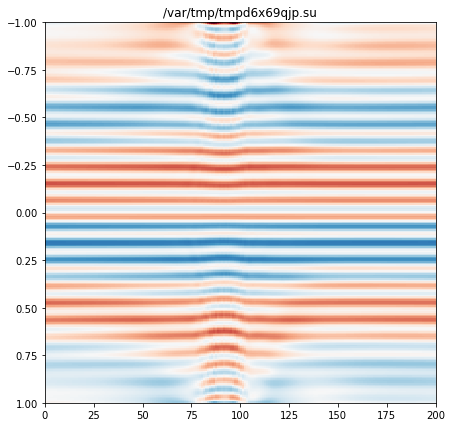

simplot: data min = -9.1570e-05, data max = 9.0117e-05


In [27]:
linalg.simplot(pent0ll.data)

Output of AWI penalty op, precond=1, lens-lens

colmax=0.0006395415 colmin=-0.0006395415


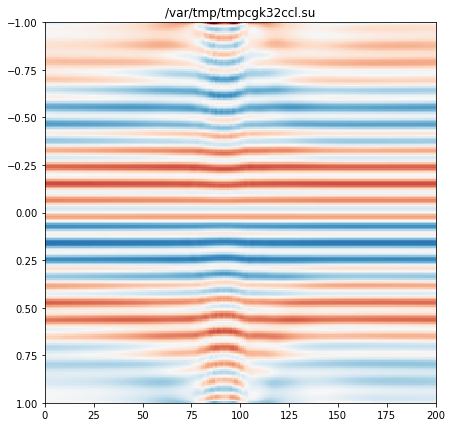

simplot: data min = -6.3954e-04, data max = 6.2939e-04


In [28]:
linalg.simplot(pent1ll.data)

AWI kernel, case hom-lens

colmax=0.039861035 colmin=-0.039861035


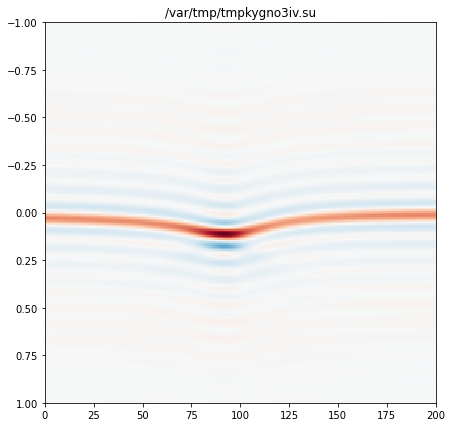

simplot: data min = -2.0777e-02, data max = 3.9861e-02


In [29]:
linalg.simplot(baruhl.data)

Output of AWI penalty op, precond=0, hom-lens

colmax=0.00047833243 colmin=-0.00047833243


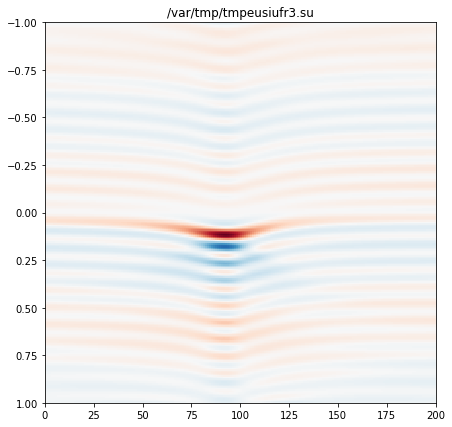

simplot: data min = -3.7329e-04, data max = 4.7833e-04


In [30]:
linalg.simplot(pent0hl.data)

Output of AWI penalty op, precond=1, hom-lens

colmax=0.0016896393 colmin=-0.0016896393


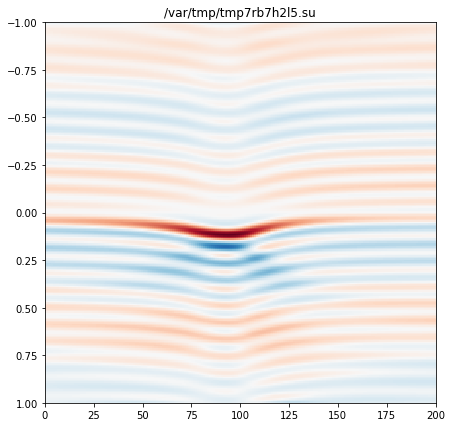

simplot: data min = -1.3157e-03, data max = 1.6896e-03


In [31]:
linalg.simplot(pent1hl.data)